# Hierarchical Linear Regression

We revisit the [Leinhardt infant mortality dataset](https://vincentarelbundock.github.io/Rdatasets/doc/carData/Leinhardt.html). In previous notebooks ([this](http://localhost:8888/notebooks/w03-07b-pymc3-model.ipynb), [this](http://localhost:8888/notebooks/w03-07c-model-checking.ipynb), and [this one](http://localhost:8888/notebooks/w03-07d-alternative-models.ipynb)), we have built various models around this data.

So far, we haven't considered the `region` variable to explain infant mortality. It does appear believable that infant mortality could depend on the region the child was born, so `region` could serve as the basis for a hierarchical model.

Here we look at the random intercept model, where the intercept is no longer drawn from a flat prior distribution, but is dependent on an underlying region distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Load Data

In [3]:
try:
    leinhardt_df = pd.read_csv("Leinhardt.csv", index=False)
except:
    leinhardt_df = pd.read_csv("https://vincentarelbundock.github.io/Rdatasets/csv/carData/Leinhardt.csv")
    leinhardt_df.to_csv("Leinhardt.csv")
    
leinhardt_df.head()

,Unnamed: 0,income,infant,region,oil
0,Australia,3426,26.7,Asia,no
1,Austria,3350,23.7,Europe,no
2,Belgium,3346,17.0,Europe,no
3,Canada,4751,16.8,Americas,no
4,Denmark,5029,13.5,Europe,no


In [4]:
leinhardt_df["is_oil"] = pd.factorize(leinhardt_df["oil"])[0]
leinhardt_df["region_f"] = pd.factorize(leinhardt_df["region"])[0]

leinhardt_df["log_income"] = np.log(leinhardt_df["income"])
leinhardt_df["log_infant"] = np.log(leinhardt_df["infant"])

leinhardt_df.dropna(subset=["log_income", "log_infant"], inplace=True)

In [5]:
leinhardt_df.head()

,Unnamed: 0,income,infant,region,oil,is_oil,region_f,log_income,log_infant
0,Australia,3426,26.7,Asia,no,0,0,8.139149,3.284664
1,Austria,3350,23.7,Europe,no,0,1,8.116716,3.165475
2,Belgium,3346,17.0,Europe,no,0,1,8.115521,2.833213
3,Canada,4751,16.8,Americas,no,0,2,8.466110,2.821379
4,Denmark,5029,13.5,Europe,no,0,1,8.522976,2.602690


## Confounding Variable?

We also want to check if the `is_oil` variable is strongly correlated with the `region_f` (factorized `region`) variable. If it is, then there is a chance for potential confounding because we won't know which variable is influencing `infant` mortality.

It appears from the output below that the oil producing countries are distributed almost uniformly across all the regions, so they are not related.

In [6]:
pd.crosstab(leinhardt_df["region_f"], leinhardt_df["is_oil"])

is_oil,0,1
region_f,,
0,24,3
1,18,0
2,20,2
3,31,3


## Define Model

In a typical linear regression model, the response variable y is a weighted sum of the explanatory variables. We have seen in previous notebooks that `infant` and `income` are not linearly related but `log(infant)` and `log(income)` are, so we use these instead.

$$ y = \beta_0 + \beta_1 * x_1 + \beta_2 * x_2 $$

Here y is `log(infant)`, $x_1$ is `log(income)`, $x_2$ is `is_oil`. Instead of drawing all the $\beta$ coefficients from the same distribution family, we will make a hierarchical model called the random intercept model, where the $\beta_0$ intercept coefficient is drawn from a region specific family of distributions.

In [7]:
num_regions = len(leinhardt_df["region"].unique())
region_idx = leinhardt_df["region_f"].values

x1 = leinhardt_df["log_income"].values
x2 = leinhardt_df["is_oil"].values
y = leinhardt_df["log_infant"].values

In [8]:
model_1 = pm.Model()
with model_1:
    mu_b0 = pm.Normal("mu_b0", mu=0, sigma=1e3)
    sig_b0 = pm.InverseGamma("sig_b0", alpha=0.5, beta=0.2)
    
    b0_coeff = pm.Normal("b0_coeff", mu=mu_b0, sigma=sig_b0, shape=num_regions)
    b_coeffs = pm.Normal("b_coeffs", mu=0, sigma=1e3, shape=2)
    
    prec = pm.InverseGamma("prec", alpha=2.5, beta=0.04)
    pred = b0_coeff[region_idx] + (b_coeffs[0] * x1) + (b_coeffs[1] * x2)
    
    y_obs = pm.Normal("y_obs", mu=pred, sigma=prec, observed=y)
    
    trace_1 = pm.sample(5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [prec, b_coeffs, b0_coeff, sig_b0, mu_b0]
Sampling 4 chains, 9 divergences: 100%|██████████| 24000/24000 [00:51<00:00, 465.46draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


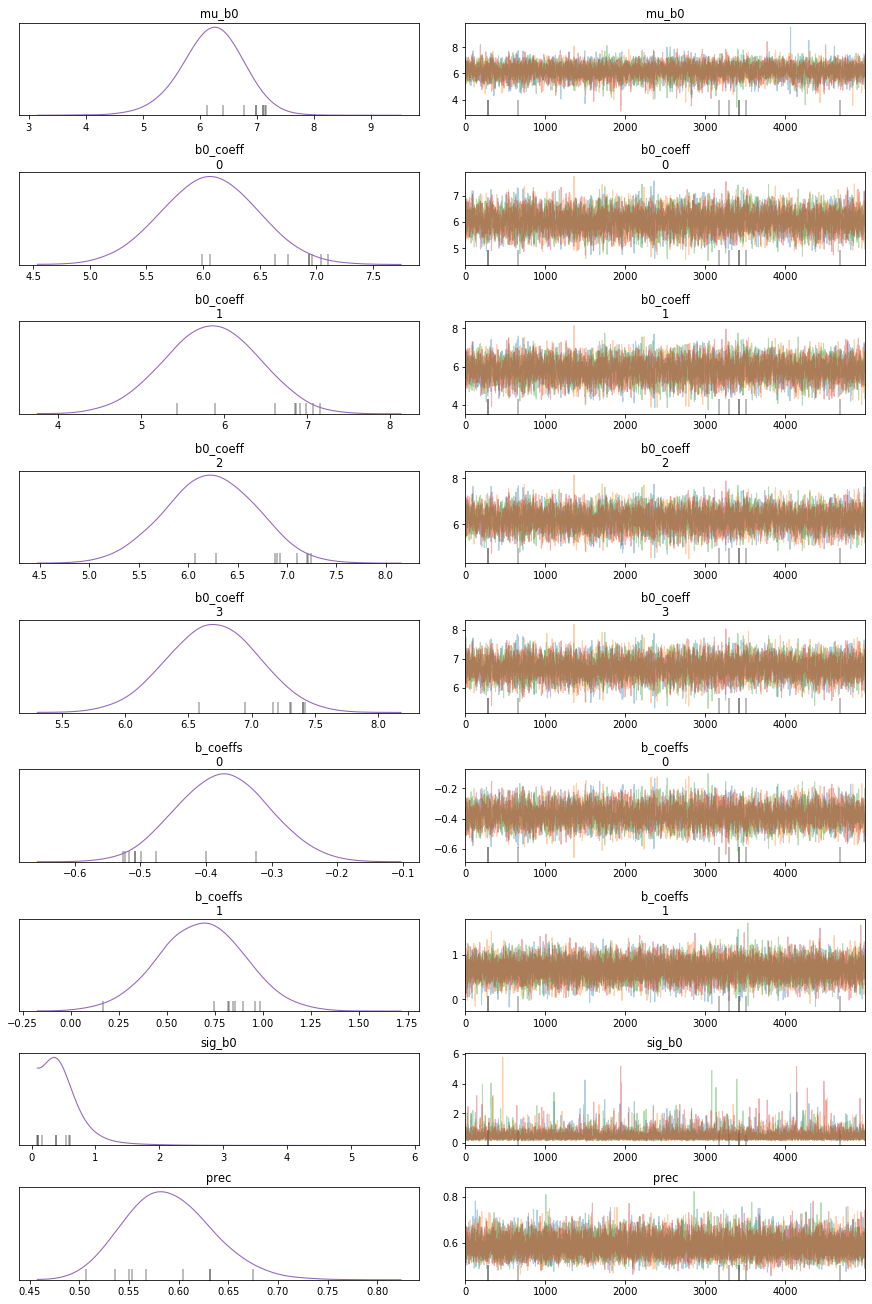

In [9]:
_ = pm.traceplot(trace_1, combined=True, compact=False)

In [10]:
pm.summary(trace_1)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_b0,6.200,0.531,5.190,7.185,0.007,0.005,5314.0,5314.0,5359.0,7771.0,1.0
b0_coeff[0],6.053,0.415,5.280,6.837,0.006,0.004,4844.0,4837.0,4847.0,7267.0,1.0
b0_coeff[1],5.841,0.561,4.796,6.886,0.008,0.006,4719.0,4714.0,4719.0,6972.0,1.0
b0_coeff[2],6.221,0.454,5.379,7.077,0.007,0.005,4794.0,4781.0,4794.0,7320.0,1.0
b0_coeff[3],6.690,0.357,6.036,7.373,0.005,0.004,4964.0,4962.0,4962.0,7319.0,1.0
b_coeffs[0],-0.375,0.069,-0.499,-0.242,0.001,0.001,4682.0,4669.0,4683.0,6601.0,1.0
b_coeffs[1],0.676,0.224,0.257,1.097,0.002,0.002,11028.0,10718.0,11070.0,10551.0,1.0
sig_b0,0.501,0.336,0.124,1.020,0.005,0.003,5368.0,5368.0,6645.0,7080.0,1.0
prec,0.590,0.044,0.510,0.671,0.000,0.000,11060.0,10933.0,11208.0,10503.0,1.0


## Model Findings

* Coefficients $\beta_1$ and $\beta_2$ are smaller than the previous models, but the signs are the same (and interpretable) since higher `infant` linked with lower `income` and higher `is_oil`. Smaller coefficients because the region intercept explains more of the mortality.
* Intercept coefficient different by region, baseline intercept is given by `mu_b0` and baseline variability is given by `sig_b0`.